In [1]:
import pandas as pd
import numpy as np
import os
import json
import time
import datetime
from chessratings import uscf_elo
import wine_data_cleanup as wdc
from matplotlib import pyplot as plt

pd.set_option('mode.chained_assignment', None)

The output files from our web scraper are JSONs. We first need to combine these JSONs into a single dataframe.

In [2]:
all_wine_reviews = []
for f in os.listdir('raw_data'):
    filename = 'raw_data/' + f
    with open(filename, 'r') as contents:
        user_wine_reviews = json.loads(contents.read())
        user_id = f.split('.')[0]
        scrape_date_unix = os.path.getmtime(filename)
        scrape_date = datetime.datetime.fromtimestamp(scrape_date_unix)
        for u in user_wine_reviews:
            u['reviewer'] = user_id
            u['scrape_date'] = scrape_date
            all_wine_reviews.append(u)

wine_review_df = pd.json_normalize(all_wine_reviews)
wine_review_df.head()

,wine_id,review_date,review_time_ago,vintage,rating,wine_name,producer,region_name,country_name,average_rating,nr_ratings,reviewer,scrape_date
0,159717279,"Thu, Apr 29th at 16:24:15 UTC",2 days ago,2019,3.5,Chianti,Sensi,Chianti,Italy,"3,3",279,30112979,2021-05-01 20:02:23.750630
1,157184020,"Wed, Apr 28th at 15:59:40 UTC",3 days ago,2018,3.0,La Chapelle de Pied Vaurias Côtes-du-Rhône,Vignerons de l'Enclave,Côtes-du-Rhône,France,"3,3",264,30112979,2021-05-01 20:02:23.750630
2,160175069,"Mon, Apr 26th at 16:21:29 UTC",5 days ago,2019,4.0,Valpolicella Ripasso Classico Superiore,Villa Mondi,Valpolicella Ripasso,Italy,"3,7",89,30112979,2021-05-01 20:02:23.750630
3,168019781,"Sun, Apr 25th at 15:56:30 UTC",6 days ago,2019,3.0,Vida Libre Blanco,Carlos Ruben,Vino de España,Spain,"0,0",2,30112979,2021-05-01 20:02:23.750630
4,163444783,"Fri, Apr 23rd at 15:53:49 UTC",8 days ago,2020,3.5,MV Malbec,Mendoza Vineyards,Mendoza,Argentina,"3,7",148,30112979,2021-05-01 20:02:23.750630


We can now use our raw datafile to create two tables: 

1. A table containing wine metadata that we can use to slice and dice our results during analysis
2. A table we can use to feed data into our ELO algorithm

In [3]:
# create a dataframe containing metadata about each wine in our dataset

wine_metadata = wine_review_df[['wine_id', 'vintage', 'wine_name', 'producer', 'region_name', 'country_name', 'nr_ratings']].drop_duplicates()
# wine_metadata['wine_vintage_id'] = wine_metadata.apply(lambda x: x['wine_id'] + '-' + x['vintage'], axis=1)
wine_metadata.set_index('wine_id', inplace=True)
wine_metadata.head()

,vintage,wine_name,producer,region_name,country_name,nr_ratings
wine_id,,,,,,
159717279,2019,Chianti,Sensi,Chianti,Italy,279
157184020,2018,La Chapelle de Pied Vaurias Côtes-du-Rhône,Vignerons de l'Enclave,Côtes-du-Rhône,France,264
160175069,2019,Valpolicella Ripasso Classico Superiore,Villa Mondi,Valpolicella Ripasso,Italy,89
168019781,2019,Vida Libre Blanco,Carlos Ruben,Vino de España,Spain,2
163444783,2020,MV Malbec,Mendoza Vineyards,Mendoza,Argentina,148


Now, we can proceed with our second table - we first need to do some cleanup before we can convert our wine ratings to ELO scores. 

A key decision here is how we want to define a 'player' for the purposes of our ELO algorithm. In our dataset, the same wine from different vintages each have their own unique ID. This is what we want, since wines may differ drastically from year to year depending on grapegrowing and winemaking factors. A *player* is therefore defined as a given wine of a given vintage. 

In [4]:
wine_reviews_cleaned = wdc.clean_wine_reviews(wine_review_df).set_index('wine_id')
wine_reviews_cleaned.head()

,reviewer,vintage,rating,final_review_date
wine_id,,,,
159717279,30112979,2019,3.5,2021-04-29
157184020,30112979,2018,3.0,2021-04-28
160175069,30112979,2019,4.0,2021-04-26
168019781,30112979,2019,3.0,2021-04-25
163444783,30112979,2020,3.5,2021-04-23


We're almost ready to compute our ELO scores. We still, however, need to do a key transformation. Currently, our wine ratings are scores out of 5. In order to compute an ELO score for our wines, we will need to model this as a zero-sum problem. We will do this by creating pairwise combinations of wines reviewed by the same person on the same day. A hypothetical example to illustrate:

Reviewer John reviewed 3 different wines on April 29th, 2021: wine A, wine B and wine C. Wine A received 5/5 points and wines B and C received 4/5. As a head-to-head zero sum game these results would look as follows:

- Wine A vs. Wine B: Wine A wins, Wine B loses
- Wine A vs. Wine C: Wine A wins, Wine C loses
- Wine B vs. Wine C: Draw

These three head-to-head **matches** can be grouped together in what we will call a **tournament**. 




In [7]:
# we need to define a score lookup table, which we will use to 
score_lookup_table_columns = ['wine_id', 'tournament_date', 'tournament_number', 'elo_rating', 'nr_games_played', 'nr_wins', 'nr_losses', 'reviewer']
score_lookup_table = pd.DataFrame(columns=score_lookup_table_columns)
all_results = wdc.run_tournaments(wine_reviews_cleaned, score_lookup_table)

all_results.to_csv('all_results.csv')
all_results.head()

,wine_id,tournament_date,tournament_number,elo_rating,nr_games_played,nr_wins,nr_losses,reviewer


In [6]:
results_grouped = all_results.groupby('wine_id').agg({'tournament_date': 'max', 'nr_games_played': 'sum', 'nr_wins': 'sum', 'nr_draws': 'sum', 'nr_losses': 'sum', 'tournament_number': 'max'}).reset_index()

results_grouped_with_score = pd.merge(results_grouped, all_results[['wine_id', 'tournament_date', 'elo_rating']], how='left', on=['wine_id', 'tournament_date']).drop_duplicates(subset=['wine_id'])

results_grouped_with_score.head(10)

,wine_id,tournament_date,nr_games_played,nr_wins,nr_draws,nr_losses,tournament_number,elo_rating
0,"(100011128-2015, 100011128-2015)",2017-07-31,3,0,1.0,2,1,1033.333333
1,"(10001226-2014, 10001226-2014)",2017-09-14,10,2,2.0,6,1,1119.611574
2,"(10001717-2013, 10001717-2013)",2017-08-28,21,13,8.0,0,3,1652.481579
3,"(10002017-2014, 10002017-2014)",2019-09-18,13,6,5.0,2,1,1415.577358
4,"(100020527-2016, 100020527-2016)",2019-05-17,6,6,0.0,0,1,1939.876371
5,"(100028032-2014, 100028032-2014)",2018-05-14,11,3,1.0,7,1,1182.475851
6,"(100039622-2016, 100039622-2016)",2019-08-10,15,0,4.0,11,1,980.648122
7,"(100040260-2016, 100040260-2016)",2018-11-11,24,10,8.0,6,7,1492.198008
8,"(100040593-N.V., 100040593-N.V.)",2020-05-01,8,2,1.0,5,2,1179.848370
9,"(100045573-2016, 100045573-2016)",2018-08-29,3,0,0.0,3,1,500.000000


In [7]:
multi_tournament_contenders = results_grouped_with_score.loc[(results_grouped_with_score['tournament_number'] >= 10) & (results_grouped_with_score['nr_games_played'] > 25)]

multi_tournament_contenders.sort_values(by=['elo_rating'], ascending=False).head(15)

,wine_id,tournament_date,nr_games_played,nr_wins,nr_draws,nr_losses,tournament_number,elo_rating
164383,"(3410815-2010, 3410815-2010)",2020-09-17,73,61,9.0,3,11,2680.572524
58199,"(152394404-2017, 152394404-2017)",2021-03-27,168,118,45.0,5,21,2612.261545
20153,"(1389995-2004, 1389995-2004)",2021-04-13,65,54,11.0,0,10,2054.637657
77031,"(156218820-2018, 156218820-2018)",2021-04-05,99,55,35.0,9,25,1942.347178
130037,"(1787087-2005, 1787087-2005)",2020-12-29,77,63,13.0,1,12,1887.860217
36222,"(145787275-2015, 145787275-2015)",2019-09-08,49,46,3.0,0,10,1880.524056
134423,"(1934046-2011, 1934046-2011)",2020-10-13,263,243,16.0,4,10,1853.839493
176295,"(4478722-2003, 4478722-2003)",2020-02-17,181,154,22.0,5,10,1828.600441
16939,"(1330837-2009, 1330837-2009)",2020-09-13,61,32,25.0,4,11,1824.423202
139997,"(2123459-2010, 2123459-2010)",2020-04-29,53,39,13.0,1,10,1823.664560


In [8]:
scores_and_metadata = pd.merge(multi_tournament_contenders, wine_metadata, left_on='wine_id', right_index=True).drop_duplicates(subset=['wine_id'])
scores_and_metadata = scores_and_metadata[['wine_id', 'vintage', 'tournament_date', 'elo_rating', 'tournament_number', 'wine_name', 'producer', 'region_name', 'country_name']]

# scores_and_metadata_plus_ratings = pd.merge(scores_and_metadata, wine_review_df, on='wine_id').drop_duplicates(subset=['wine_vintage_id'])
# scores_and_metadata_plus_ratings = scores_and_metadata_plus_ratings[['wine_vintage_id', 'wine_id', 'elo_rating', 'rating', 'tournament_number', 'wine_name', 'producer', 'region_name', 'country_name']]

scores_and_metadata.sort_values(by=['tournament_number'], ascending=False).shape

(0, 9)

In [9]:
scores_and_metadata.loc[scores_and_metadata['producer'] == "Dow's"]

,wine_id,vintage,tournament_date,elo_rating,tournament_number,wine_name,producer,region_name,country_name


In [10]:
one_wine_results = all_results.loc[all_results['wine_vintage_id'] == '1934046-2011']
one_wine_results

KeyError: 'wine_vintage_id'

<AxesSubplot:xlabel='tournament_date'>

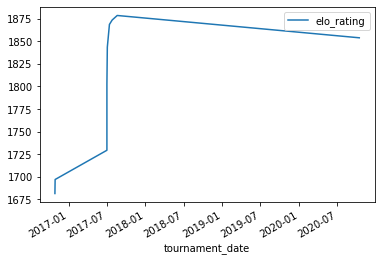

In [66]:
one_wine_results.plot(x='tournament_date', y='elo_rating', kind='line')